In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
N = 15  # Number of intervals
domain = -7, 7  # Domain in x
points = np.linspace(domain[0], domain[1], N + 1, endpoint=True)
y_real = sigmoid(points)
slopes = (y_real[1:] - y_real[:-1]) / (points[1:] - points[:-1])
intercepts = y_real[:-1] - slopes * points[:-1]

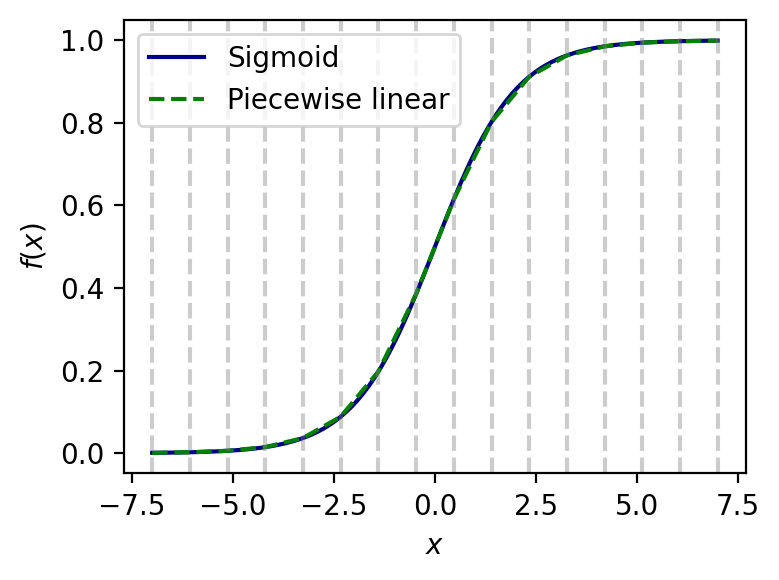

In [4]:
fig, ax = plt.subplots(figsize=[4, 3], dpi=200)
x_line = np.linspace(domain[0], domain[1], 100, endpoint=True)
y_line = sigmoid(x_line)
ax.plot(x_line, y_line, c="navy", label="Sigmoid")  # r"$ \frac{1}{1 + e^{-x}} $"
ax.plot(points, y_real, c="green", linestyle="--", label="Piecewise linear")
for xi in points:
    plt.axvline(xi, color="grey", linestyle="--", alpha=0.4)
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.legend()
fig.tight_layout()
plt.savefig("sigmoid.png", transparent=True)
plt.show()

In [5]:
# Model
model = pyo.ConcreteModel()

In [6]:
# Set
model.I = pyo.Set(initialize=range(N))

In [7]:
# Parameters
model.l = pyo.Param(model.I, initialize=points[:-1])
model.u = pyo.Param(model.I, initialize=points[1:])
model.a = pyo.Param(model.I, initialize=slopes)
model.b = pyo.Param(model.I, initialize=intercepts)

# Target in y
model.target = pyo.Param(initialize=0.6)

In [8]:
# Variables
# Basic piecewise
model.x = pyo.Var(bounds=domain, within=pyo.Reals)
model.z = pyo.Var(model.I, within=pyo.Binary)
model.s = pyo.Var(model.I, bounds=domain, within=pyo.Reals)
model.y = pyo.Var(within=pyo.Reals)

# Represent distances to target
model.dl = pyo.Var(within=pyo.NonNegativeReals)
model.du = pyo.Var(within=pyo.NonNegativeReals)

In [9]:
# Constraints
def lower_interval(model, i):
    return model.l[i] * model.z[i] <= model.s[i]


def upper_interval(model, i):
    return model.s[i] <= model.u[i] * model.z[i]


def compute_y(model):
    return model.y == sum(model.b[i] * model.z[i] + model.a[i] * model.s[i] for i in model.I)


# Basic constraints
model.one_active = pyo.Constraint(expr=sum(model.z[:]) == 1)
model.x_proj = pyo.Constraint(expr=sum(model.s[:]) == model.x)
model.lower_interval = pyo.Constraint(model.I, rule=lower_interval)
model.upper_interval = pyo.Constraint(model.I, rule=upper_interval)
model.compute_y = pyo.Constraint(rule=compute_y)


# Distance to target constraints
model.slack_lobj = pyo.Constraint(expr=model.dl + model.target <= model.y)
model.slack_uobj = pyo.Constraint(expr=model.y <= model.target + model.du)

In [10]:
# Objective
model.obj = pyo.Objective(expr=model.dl + model.du, sense=pyo.minimize)

In [11]:
solver = pyo.SolverFactory("appsi_highs")

In [12]:
solver.solve(model)

{'Problem': [{'Lower bound': 0.0, 'Upper bound': 0.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 1}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [13]:
print(f"f(x): {sigmoid(model.x.value):.3f} vs target {model.target.value:.3f}")

f(x): 0.600 vs target 0.600


In [14]:
model.x.pprint()

x : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :    -7 : 0.4072330467184529 :     7 : False : False :  Reals


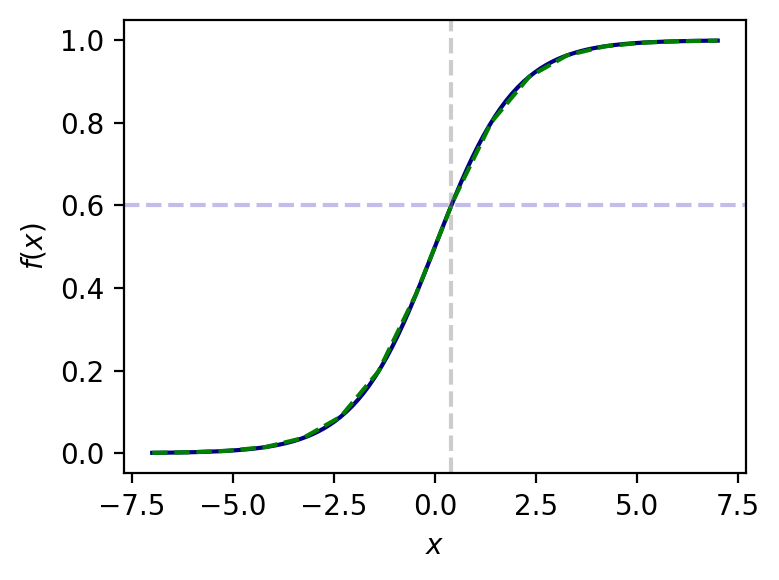

In [15]:
fig, ax = plt.subplots(figsize=[4, 3], dpi=200)
x_line = np.linspace(domain[0], domain[1], 100, endpoint=True)
y_line = sigmoid(x_line)
ax.plot(x_line, y_line, c="navy", label="Sigmoid")  # r"$ \frac{1}{1 + e^{-x}} $"
ax.plot(points, y_real, c="green", linestyle="--", label="Piecewise linear")
plt.axvline(model.x.value, color="grey", linestyle="--", alpha=0.4, label=f"Solution {model.x.value:.3f}")
plt.axhline(model.target.value, color="slateblue", linestyle="--", alpha=0.4, label=f"Target {model.target.value:.3f}")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
# ax.legend()
fig.tight_layout()
plt.savefig("sigmoid_solution.png", transparent=True)
plt.show()